In [30]:
import tweepy
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from nltk.tokenize import TweetTokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [3]:
#Authenticate with credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [7]:
key_word = 'tesla'
limit = 500

In [20]:
def TextClean(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'#[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'&[a-z0-9_]\S+', '', tweet)
    tweet = re.sub(r'[?!.+,;$%&"]+', '', tweet)
    tweet = re.sub(r'rt[\s]+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\$', '', tweet)
    tweet = re.sub(r'rt+', '', tweet)
    tweet = re.sub(r'https?:?\/\/\S+', '', tweet)
    
    return tweet

In [21]:
def tweet_search(key_word):
    i = 0
    tweets_df = pd.DataFrame(columns=['Datetime', 'Tweet', 'Username', 'Retweets', 'Followers'])
    for tweet in tweepy.Cursor(api.search, q = key_word, count = 100, lang = 'en', tweet_mode = 'extended').items():
        print('Tweets downloaded:', i, '/', limit, end = '\r')
        if tweet.user.followers_count > 500:
            tweets_df = tweets_df.append({'Datetime': tweet.created_at,
                                          'Tweet': tweet.full_text,
                                          'Username': tweet.user.screen_name,
                                          'Retweets': tweet.retweet_count,
                                          'Followers': tweet.user.followers_count}, ignore_index = True)
            i += 1
        if i >= limit:
            break
        else:
            pass
        
    tweets_df['Datetime'] = pd.to_datetime(tweets_df['Datetime'], format = '%Y.%m.%d %H:%M:%S')
    tweets_df.set_index('Datetime', inplace = True)
    tweets_df.drop_duplicates(subset = ['Tweet'], inplace = True)
    tweets_df['CleanTweet'] = tweets_df['Tweet'].apply(TextClean)
    tweet_tokenizer = TweetTokenizer()
    tweets_df['CleanTweet'] = tweets_df['CleanTweet'].apply(tweet_tokenizer.tokenize)
    tweets_df['CleanTweet'] = [', '.join(map(str, token)) for token in tweets_df['CleanTweet']]
    #tweets_df.to_csv(key_word + '.csv', encoding='utf-8')
    
    return tweets_df

In [22]:
tweets_df = tweet_search(key_word)
tweets_df

,Tweet,Username,Retweets,Followers,CleanTweet
Datetime,,,,,
2020-09-30 05:54:38,RT @4TheCulture____: It’s time to get a Tesla ...,TheOnlyAgnecias,13336,1914,"it, ’, s, time, to, get, a, tesla, 🔥, 🔥, 😳"
2020-09-30 05:53:43,@DooleyAgent @SmokeyShorts @elonmusk @Tesla O ...,maggiejuang1,0,779,"o, nice, why, are, some, tesla, seats, white, ..."
2020-09-30 05:53:34,@VanderJ97 Buy Tesla cuz vaccine!!,DestoLeafs,0,517,"buy, tesla, cuz, vaccine"
2020-09-30 05:53:17,RT @CoZza_86: @rstefani11 @elonmusk @Tesla A f...,CoZza_86,2,1347,"a, flayming, tesla"
2020-09-30 05:52:54,RT @28delayslater: 😱 look what the #Tesla deli...,RameshTwts,90,1967,"😱, look, what, the, delivery, team, did"
...,...,...,...,...,...
2020-09-30 04:27:26,The Tesla Semi is helping deliver in Q3’20. Tr...,teslaownersSV,16,29792,"the, tesla, semi, is, helping, deliver, in, q,..."
2020-09-30 04:27:15,I’m over here trying to win a fucking Tesla fr...,meli_cxx,0,794,"i, ’, m, over, here, trying, to, win, a, fucki..."
2020-09-30 04:27:12,Well I’m in love all over again!!! This @Tesla...,TeslaChillMode,0,1907,"well, i, ’, m, in, love, all, over, again, thi..."


In [27]:
def vader_compound_score(tweet):
    vader = SentimentIntensityAnalyzer()
    if vader.polarity_scores(tweet)['compound'] >= 0.05:
        return 'Positive'
    elif vader.polarity_scores(tweet)['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
def textblob_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [31]:
tweets_df['Vader_sent'] = tweets_df['CleanTweet'].apply(vader_compound_score)
tweets_df['TextBlob_sent'] = tweets_df['CleanTweet'].apply(textblob_sentiment)
tweets_df['Different_sent'] = np.where(tweets_df['Vader_sent'] != tweets_df['TextBlob_sent'], 1, 0)

In [32]:
tweets_df

,Tweet,Username,Retweets,Followers,CleanTweet,Vader_sent,TextBlob_sent,Different_sent
Datetime,,,,,,,,
2020-09-30 05:54:38,RT @4TheCulture____: It’s time to get a Tesla ...,TheOnlyAgnecias,13336,1914,"it, ’, s, time, to, get, a, tesla, 🔥, 🔥, 😳",Negative,Neutral,1
2020-09-30 05:53:43,@DooleyAgent @SmokeyShorts @elonmusk @Tesla O ...,maggiejuang1,0,779,"o, nice, why, are, some, tesla, seats, white, ...",Positive,Positive,0
2020-09-30 05:53:34,@VanderJ97 Buy Tesla cuz vaccine!!,DestoLeafs,0,517,"buy, tesla, cuz, vaccine",Neutral,Neutral,0
2020-09-30 05:53:17,RT @CoZza_86: @rstefani11 @elonmusk @Tesla A f...,CoZza_86,2,1347,"a, flayming, tesla",Neutral,Neutral,0
2020-09-30 05:52:54,RT @28delayslater: 😱 look what the #Tesla deli...,RameshTwts,90,1967,"😱, look, what, the, delivery, team, did",Negative,Neutral,1
...,...,...,...,...,...,...,...,...
2020-09-30 04:27:26,The Tesla Semi is helping deliver in Q3’20. Tr...,teslaownersSV,16,29792,"the, tesla, semi, is, helping, deliver, in, q,...",Positive,Positive,0
2020-09-30 04:27:15,I’m over here trying to win a fucking Tesla fr...,meli_cxx,0,794,"i, ’, m, over, here, trying, to, win, a, fucki...",Negative,Negative,0
2020-09-30 04:27:12,Well I’m in love all over again!!! This @Tesla...,TeslaChillMode,0,1907,"well, i, ’, m, in, love, all, over, again, thi...",Positive,Positive,0


In [35]:
#Visualisation
vader_pie = [len(tweets_df[tweets_df['Vader_sent'] == 'Positive']), 
             len(tweets_df[tweets_df['Vader_sent'] == 'Negative']), 
             len(tweets_df[tweets_df['Vader_sent'] == 'Neutral'])]
blob_pie = [len(tweets_df[tweets_df['TextBlob_sent'] == 'Positive']), 
            len(tweets_df[tweets_df['TextBlob_sent'] == 'Negative']), 
            len(tweets_df[tweets_df['TextBlob_sent'] == 'Neutral'])]
labels = ['Positive', 'Negative', 'Neutral']
colors = ['aquamarine', 'tomato', 'skyblue']

117 times two approaches show different results


Text(0.5, 1.0, 'TextBlob')

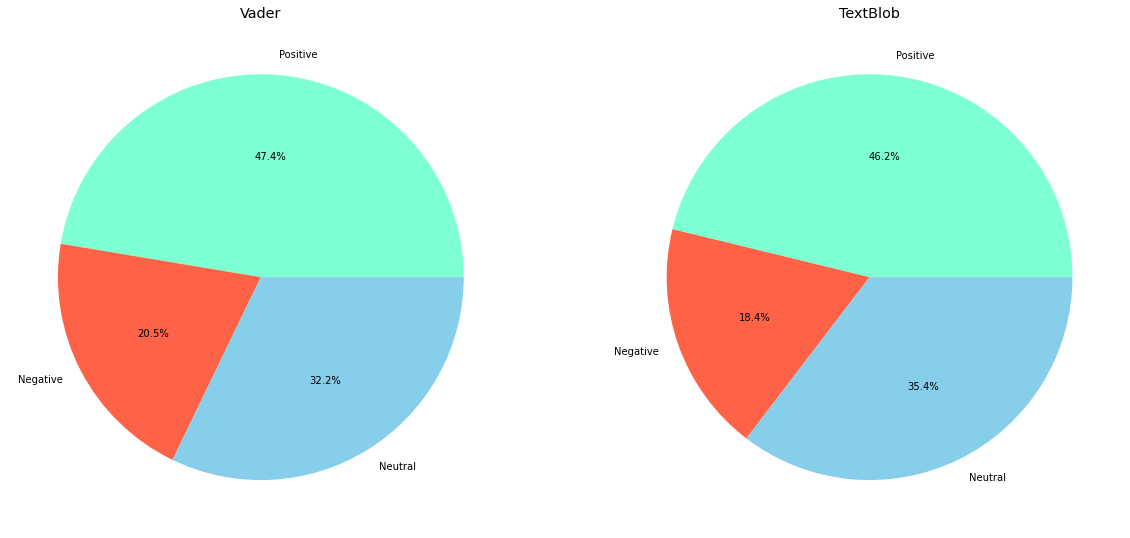

In [41]:
print(len(tweets_df[tweets_df['Different_sent'] == 1]), 'times two approaches show different results')

plt.style.use('ggplot')
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.pie(vader_pie, labels = labels, colors = colors, autopct = '%1.1f%%')
plt.title('Vader')

plt.subplot(1, 2, 2)
plt.pie(blob_pie, labels = labels, colors = colors, autopct = '%1.1f%%')
plt.title('TextBlob')